In [281]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

"""
Argumentos:
    dataframe (Pandas Dataframe): Un dataframe que contiene las coordenadas del problema RecocidoSimulado.
    alfa (flotante, opcional): la cantidad por la que se multiplica la temperatura en cada paso. Debe ser inferior a 1. El valor predeterminado es 0,99.
    gamma (int, opcional): la cantidad por la que se multiplica la temperatura inicial en cada paso. El valor predeterminado es 1.
    all_distances (Bool, opcional): elige si quieres devolver todas las distancias y temperaturas.
    return_solution (Bool, opcional): elige si devolver la solución.
    K (int, opcional): Temperatura de inicio. El valor predeterminado es 2.
    markov_length (int, opcional): La longitud de la cadena de markov a cada temperatura. El valor predeterminado es 100.
    stopK (flotante, opcional): La temperatura final. El valor predeterminado es 0.1.
"""
class RecSimuViajero():
    def __init__(self, dataframe, K = 2, markov_length = 100, stopK = 0.1, alpha = 0.99,gamma=1, 
        all_distances=False, return_solution=False):
        assert alpha < 1, "Alpha debe ser <1"
        self.df = dataframe
        self.K = K
        self.startK = K
        self.stopK = stopK
        self.alpha = alpha
        self.gamma = gamma
        self.markov_length = markov_length
        self.all_distances = all_distances
        self.return_solution = return_solution

            
        # start with a simple solution
        self.dist_matrix = self.matriz_distancias()
        self.solution = self.vecinos_cercanos()

    def matriz_distancias(self):
        """Una matriz con la distancia entre dos ciudades"""
        matrix = np.zeros((len(self.df),len(self.df)))
        for row in range(len(self.df)):
            fro = self.df.loc[row]
            for column in range(len(self.df)):
                if row != column:
                    to = self.df.loc[column]
                    matrix[row][column] = self.eval_funct(fro["x"], fro["y"], to["x"], to["y"])
        
        return matrix

    def vecinos_cercanos(self):
        """Lista con el orden de las ciudades que se recorren.
        """
        free_nodes = []
        for row in range(self.df.shape[0]):
            free_nodes.append(self.df.iloc[row].name)

        sol = []
        cur_node = self.df.loc[random.choice(free_nodes)]
        sol.append(cur_node.name)
        free_nodes.remove(cur_node.name)

        while free_nodes:
            first = True
            for node in free_nodes:
                next_node = self.df.loc[node]
                new_dist = self.eval_funct(cur_node["x"], cur_node["y"], next_node["x"], next_node["y"])
                if first:
                    closest = node
                    old_distance = new_dist
                    first = False
                else: 
                    if new_dist < old_distance:
                        closest = node
                        old_distance = new_dist
            sol.append(closest)
            cur_node = self.df.loc[closest]
            free_nodes.remove(closest)

        return sol
    def intercambio(self):
        """Intercambio de ciudades"""
        i1, i2 = random.sample(range(0, len(self.solution)-1), 2)
        new_solution = self.solution[:]
        new_solution[i1], new_solution[i2] = new_solution[i2], new_solution[i1]
        return new_solution


    def eval_funct(self,x1, y1, x2, y2) :
        """Calcula la distancia euclidiana entre dos ciudades"""
        return np.sqrt((x1-x2)**2 + abs(y1-y2)**2)


    def costo_total(self, solution = -1):
        """La distancia total recorrida"""
        if solution == -1:
            solution = self.solution
        distance = 0
        for i in range(len(solution)-1):
            distance += self.dist_matrix[int(solution[i])-1][int(solution[i+1])-1]
        # make it a circle
        distance += self.dist_matrix[int(solution[i+1])-1][int(solution[0])-1]
        return distance
    def algoritmo(self):
        self.startK=self.startK * self.gamma
        self.K = self.startK
        return self.recocido_simulado()
    def recocido_simulado(self):
        assert self.alpha < 1, "debe ser un alpha menor a 1"
        all_dist = []
        temperature = []
        old_distance = self.costo_total()
        i=0
        while(self.K>self.stopK):
            # run an epoch
            for i in range(self.markov_length):
                temperature.append(self.K)
                all_dist.append(self.costo_total())
                new_solution = self.intercambio()

                new_dist = self.costo_total(new_solution)
                # decide whether to accept the new solution
                if new_dist < old_distance:
                    self.solution = new_solution
                    old_distance = self.costo_total()
                else:
                    # accept with probability depending on temperature
                    rand = np.random.random()
                    prob = math.exp((-1*(new_dist - old_distance)) / self.K )
                    if rand < prob:
                        self.solution = new_solution
                        old_distance = self.costo_total()
            # scale the cooling scheme to start lower every next simulation
            self.K *= self.alpha 

        if self.all_distances:
            returns = [all_dist, temperature]
        else:
            returns = self.costo_total()
        if self.return_solution:
            returns = [returns, self.solution]
            
        print("Ruta más corta:% s"%self.costo_total())
 
        return returns



    def plot_solution(self, color_graph):
        self.df.plot.scatter("x", "y",color=color_graph )
        for i in range(len(self.solution)-1):
            fro = self.df.loc[self.solution[i]]
            to = self.df.loc[self.solution[i+1]]
            plt.arrow(fro["x"], fro["y"], to["x"]-fro["x"], to["y"]-fro["y"])
        fro = self.df.loc[self.solution[len(self.solution)-1]]
        to = self.df.loc[self.solution[0]]
        plt.arrow(fro["x"], fro["y"], to["x"]-fro["x"], to["y"]-fro["y"])




In [282]:
import pandas as pd
df = pd.DataFrame(np.random.uniform(low=0,high=1,size=(30, 2)), columns=list('xy'))
df1 = df.iloc[:int(df.shape[0]/3)]
df2 = df.iloc[int(df.shape[0]/3):int(df.shape[0]*2/3)]
index=df2.reset_index().index.values
df2=df2.set_index(index)
df3 = df.iloc[int(df.shape[0]*2/3):]
index=df3.reset_index().index.values
df3=df3.set_index(index)

In [283]:
sim1 = RecSimuViajero(df1, K=200,stopK=.001, alpha = 0.99, all_distances=True,markov_length = 300)
ans1 = sim1.algoritmo()

Ruta más corta:2.897043713840269


In [284]:
sim2 = RecSimuViajero(df2, K=200, stopK=.001, alpha = 0.99, all_distances=True,markov_length = 200)
ans2 = sim2.algoritmo()

Ruta más corta:2.9414240665881852


In [285]:
sim3 = RecSimuViajero(df3, K=200, stopK=.001, alpha = 0.99, all_distances=True,markov_length = 100)
ans3 = sim2.algoritmo()

Ruta más corta:2.941424066588185


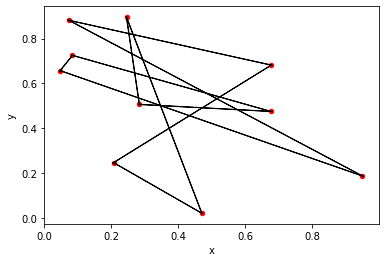

In [286]:
sim1.plot_solution('red')

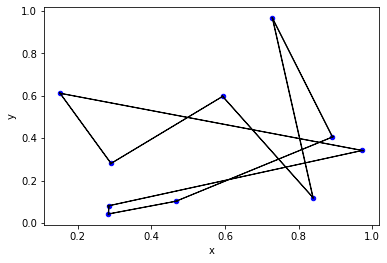

In [287]:
sim2.plot_solution('blue')

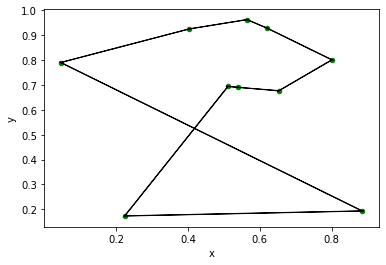

In [288]:
sim3.plot_solution('green')